In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from tqdm import tqdm
import bz2
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='whitegrid')

/Users/filipposalmina/.conda/envs/ada/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
data_folder = './data/' #TODO: put at the beggin in order to save the dataset directly in right folder.
path_dataset = data_folder + 'quotes-2020-clean.json.bz2' # path
path_dataset_clean_2020 = data_folder + 'quotes-2020-clean_classified.json.bz2' # path to cleaned dataset
df_2020 = pd.read_json(path_dataset_clean_2020, lines=True, compression='bz2')
df_2020.head(3)

,quotation,speaker,date,qids,urls,label
0,coupled solid institutions measured world bank...,Lim Guan Eng,2020-01-22,Q707164,themalaymailonline.com,0
1,economy free market threat socialism,Frank Pavone,2020-04-04,Q5488928,catholicnewsagency.com,0
2,probably first five games league youre kind ne...,Josh Morrissey,2020-02-05,Q13581454,winnipegfreepress.com,4


In [3]:
path_dataset = data_folder + 'quotes-2019-clean.json.bz2' 
path_dataset_clean_2019 = data_folder + 'quotes-2019-clean_classified.json.bz2'
df_2019 = pd.read_json(path_dataset_clean_2019, lines=True, compression='bz2')
df_2019.head(3)

,quotation,speaker,date,qids,urls,label
0,91 old awards show young youre democrat runnin...,Jimmy Fallon,2019-02-23,Q335680,govexec.com,1
1,unique show film music heart show great perfor...,Ranveer Singh,2019-02-06,Q902879,tribune.com.pk,1
2,hatched conspiracy destabilise tdp government ...,Chandrababu Naidu,2019-03-11,Q3518013,aninews.in,2


In [4]:
path_dataset = data_folder + 'quotes-2018-clean.json.bz2' 
path_dataset_clean_2018 = data_folder + 'quotes-2018-clean_classified.json.bz2' 
df_2018 = pd.read_json(path_dataset_clean_2018, lines=True, compression='bz2')
df_2018.head(3)

,quotation,speaker,date,qids,urls,label
0,adi ranveer met extensively discussed next fil...,Ranveer Singh,2018-03-13,Q902879,bollywoodhungama.com,1
1,games half lineups half,Rod Brind ` amour,2018-10-01,Q949869,wncn.com,4
2,amazon offers thousands toprated toys includin...,Sriram Parthasarathy,2018-09-30,Q7586494,hulldailymail.co.uk,4


In [5]:
path_dataset = data_folder + 'quotes-2017-clean.json.bz2' 
path_dataset_clean_2017 = data_folder + 'quotes-2017-clean_classified.json.bz2' 
df_2017 = pd.read_json(path_dataset_clean_2017, lines=True, compression='bz2')
df_2017.head(3)

,quotation,speaker,date,qids,urls,label
0,labour superb saleswoman lousy product thats p...,Chris Trotter,2017-09-22,Q5108312,au.news.yahoo.com,2
1,leon bailey wanted chelsea arsenal,Leon Bailey,2017-12-26,Q20890178,dailystar.co.uk,3
2,shia labeouf character mutt williams film,David Koepp,2017-09-06,Q270178,sg.style.yahoo.com,1


In [6]:
path_dataset = data_folder + 'quotes-2016-clean.json.bz2' 
path_dataset_clean_2016 = data_folder + 'quotes-2016-clean_classified.json.bz2'
df_2016 = pd.read_json(path_dataset_clean_2016, lines=True, compression='bz2')
df_2016.head(3)

,quotation,speaker,date,qids,urls,label
0,mmigration continues good economy,Hillary Clinton,2016-07-12,Q6294,breitbart.com,0
1,aurangzeb dynamic film treat work amazing cast...,Arjun Kapoor,2016-05-11,Q2383191,india.com,1
2,carlos good manager nice guy work,Glenn Loovens,2016-04-19,Q27735,thestar.co.uk,3


In [7]:
path_dataset = data_folder + 'quotes-2015-clean.json.bz2' 
path_dataset_clean_2015 = data_folder + 'quotes-2015-clean_classified.json.bz2'
df_2015 = pd.read_json(path_dataset_clean_2015, lines=True, compression='bz2')
df_2015.head(3)

,quotation,speaker,date,qids,urls,label
0,also one males maledominated film one heroes film,Taapsee Pannu,2015-01-16,Q7672815,glamsham.com,1
1,felt good tonight seeing puck well guys chippi...,Cam Johnson,2015-12-12,Q3651108,grandforksherald.com,4
2,anything cup tasty,RICHARD CHAPLOW,2015-08-25,Q2081399,yorkshirepost.co.uk,3


In [8]:
path = data_folder + "speaker_attributes_final.json.bz2"
speaker_atr = pd.read_json(path, lines=True, compression='bz2')
speaker_atr.head(3)

,date_of_birth,nationality,gender,id
0,1732,Great Britain,male,Q23
1,1952,United Kingdom,male,Q42
2,1868,Belgium,male,Q1868


In [9]:
def merged_datasets (data1, data2) : 
    return pd.merge(data1, data2 ,how='inner' ,left_on=['qids'],right_on=['id'])

In [10]:
df_2020_merge = merged_datasets(df_2020,speaker_atr )
df_2020_merge.head(3)

,quotation,speaker,date,qids,urls,label,date_of_birth,nationality,gender,id
0,coupled solid institutions measured world bank...,Lim Guan Eng,2020-01-22,Q707164,themalaymailonline.com,0,1960,Malaysia,male,Q707164
1,impact lower tourist arrivals local economy un...,Lim Guan Eng,2020-01-31,Q707164,theedgemarkets.com,0,1960,Malaysia,male,Q707164
2,supported governments proposed initiatives pro...,Lim Guan Eng,2020-01-06,Q707164,theedgemarkets.com,0,1960,Malaysia,male,Q707164


In [11]:
df_2019_merge = merged_datasets(df_2019,speaker_atr )
df_2019_merge.head(3)

,quotation,speaker,date,qids,urls,label,date_of_birth,nationality,gender,id
0,91 old awards show young youre democrat runnin...,Jimmy Fallon,2019-02-23,Q335680,govexec.com,1,1974,United States of America,male,Q335680
1,weird testament think marvel film know antman ...,Jimmy Fallon,2019-11-21,Q335680,complex.com,1,1974,United States of America,male,Q335680
2,know whats funny saw picture holding coffee cup,Jimmy Fallon,2019-05-11,Q335680,toofab.com,3,1974,United States of America,male,Q335680


In [12]:
df_2018_merge = merged_datasets(df_2018,speaker_atr )
df_2018_merge.head(3)

,quotation,speaker,date,qids,urls,label,date_of_birth,nationality,gender,id
0,adi ranveer met extensively discussed next fil...,Ranveer Singh,2018-03-13,Q902879,bollywoodhungama.com,1,1985,India,male,Q902879
1,time way mounting film everything pumping beco...,Ranveer Singh,2018-08-06,Q902879,gulfnews.com,1,1985,India,male,Q902879
2,gully boy perhaps dearest film one closest ban...,Ranveer Singh,2018-02-11,Q902879,indianexpress.com,1,1985,India,male,Q902879


In [13]:
df_2017_merge = merged_datasets(df_2017,speaker_atr )
df_2017_merge.head(3)

,quotation,speaker,date,qids,urls,label,date_of_birth,nationality,gender,id
0,labour superb saleswoman lousy product thats p...,Chris Trotter,2017-09-22,Q5108312,au.news.yahoo.com,2,1956,New Zealand,male,Q5108312
1,dont quick condemn labour greens cautioning su...,Chris Trotter,2017-03-27,Q5108312,m.nzherald.co.nz,2,1956,New Zealand,male,Q5108312
2,think beginning jacinda effect lift labour clo...,Chris Trotter,2017-08-10,Q5108312,newstalkzb.co.nz,2,1956,New Zealand,male,Q5108312


In [14]:
df_2016_merge = merged_datasets(df_2016,speaker_atr )
df_2016_merge.head(3)

,quotation,speaker,date,qids,urls,label,date_of_birth,nationality,gender,id
0,mmigration continues good economy,Hillary Clinton,2016-07-12,Q6294,breitbart.com,0,1947,United States of America,female,Q6294
1,many wedded failed theory trickledown economic...,Hillary Clinton,2016-07-29,Q6294,vox.com,0,1947,United States of America,female,Q6294
2,answer rant rave cut world would end killing e...,Hillary Clinton,2016-08-13,Q6294,delmarvapublicradio.net,0,1947,United States of America,female,Q6294


In [15]:
df_2015_merge = merged_datasets(df_2015,speaker_atr )
df_2015_merge.head(3)

,quotation,speaker,date,qids,urls,label,date_of_birth,nationality,gender,id
0,also one males maledominated film one heroes film,Taapsee Pannu,2015-01-16,Q7672815,glamsham.com,1,1987,India,female,Q7672815
1,sobbing scenes film made celebrate relationshi...,Taapsee Pannu,2015-11-05,Q7672815,canindia.com,1,1987,India,female,Q7672815
2,67 moment film catches connections relatives a...,Taapsee Pannu,2015-11-01,Q7672815,canindia.com,1,1987,India,female,Q7672815


In [16]:
df_2015_2020_merge = pd.concat([df_2020_merge, df_2019_merge, df_2018_merge, df_2017_merge, df_2016_merge, df_2015_merge])
list_df = [df_2015_merge,df_2016_merge,  df_2017_merge, df_2018_merge, df_2019_merge,df_2020_merge ]
for i in list_df:
    i.sort_values(by=['nationality'], ascending = True,inplace=True)
years = ['2015','2016','2017','2018','2019','2020']
list_df[0].head(3)

,quotation,speaker,date,qids,urls,label,date_of_birth,nationality,gender,id
134571,idea core economy mankind,Roya Mahboob,2015-03-17,Q7373553,thenonprofittimes.com,0,1987,Afghanistan,female,Q7373553
137996,whenever ask get energy handle job withstand t...,Maria Bashir,2015-03-26,Q1528460,thinkprogress.org,4,1970,Afghanistan,female,Q1528460
132116,strong results year reaffirm success banks foc...,Murad Ali Murad,2015-02-10,Q1953460,cpifinancial.net,0,1956,Afghanistan,male,Q1953460


Which are the most rapresented new source ?

In [25]:
df_2015_2020_merge.urls.value_counts()[:2]

msn.com          4561
breitbart.com    3757
Name: urls, dtype: int64

In [26]:
df_2015_2019_merge = pd.concat([df_2019_merge, df_2018_merge, df_2017_merge, df_2016_merge, df_2015_merge])

In [192]:
df_2015_2019_merge['date_category'] = pd.cut(df_2015_2019_merge['date'],
                                             [np.datetime64('2015-01-01'),#np.datetime64('2015-03-01'),np.datetime64('2015-06-01'),np.datetime64('2015-09-01'),
                                             np.datetime64('2016-01-01'),#np.datetime64('2016-03-01'),np.datetime64('2016-06-01'),np.datetime64('2016-09-01'),
                                             np.datetime64('2017-01-01'),#np.datetime64('2017-03-01'),np.datetime64('2017-06-01'),np.datetime64('2017-09-01'),
                                             np.datetime64('2018-01-01'),#np.datetime64('2018-03-01'),np.datetime64('2018-06-01'),np.datetime64('2018-09-01'),
                                             np.datetime64('2019-01-01'),#np.datetime64('2019-03-01'),np.datetime64('2019-06-01'),np.datetime64('2019-09-01'),
                                             np.datetime64('2019-12-31')])
df_2020_merge['date_category'] = pd.cut(df_2020_merge['date'],
                                             [np.datetime64('2020-01-01'),  np.datetime64('2020-07-01')]) #np.datetime64('2020-02-01'), np.datetime64('2020-03-01'), np.datetime64('2020-04-01'),

df_2020_merge.head(3)

,quotation,speaker,date,qids,urls,label,date_of_birth,nationality,gender,id,date_category
21453,american people rely terrorists safeguard secu...,Sirajuddin Haqqani,2020-02-28,Q2246940,business-standard.com,4,1970,Afghanistan,cisgender male,Q2246940,"(2020-01-01, 2020-07-01]"
29713,extraordinary work inzaghi staff crazy atmosph...,Igli Tare,2020-02-04,Q472159,football-italia.net,4,1973,Albania,cisgender male,Q472159,"(2020-01-01, 2020-07-01]"
3953,aim first foremostmust ensure full sustainable...,Edi Rama,2020-01-23,Q316901,ukrinform.net,4,1964,Albania,cisgender male,Q316901,"(2020-01-01, 2020-07-01]"


In [193]:
df_2015_2019_merge.head(2)

,quotation,speaker,date,qids,urls,label,date_of_birth,nationality,gender,id,date_category
123017,big teams playing among long icc asian cricket...,Emal Pasarly,2019-06-22,Q16212719,tribuneindia.com,3,1974,Afghanistan,cisgender male,Q16212719,"(2019-01-01, 2019-12-31]"
115093,want work hard game become bestever player pro...,Ikram Ali Khil,2019-07-05,Q39721989,orissapost.com,3,2000,Afghanistan,cisgender male,Q39721989,"(2019-01-01, 2019-12-31]"


In [194]:
def regroup_genders(df):
    #raplacing other genders by an umbrella term
    df.replace('genderfluid', 'genderqueer', inplace = True)
    df.replace('non-binary', 'genderqueer', inplace = True)
    df.replace('intersex', 'genderqueer', inplace = True)
    df.replace('transgender female', 'genderqueer', inplace = True)
    df.replace('transgender male', 'genderqueer', inplace = True)
    df.replace('shemale', 'genderqueer', inplace = True)
    df.replace('transmasculine', 'genderqueer', inplace = True)
    
    #regrouping trans and cis females under females
    df.replace('male', 'cisgender male', inplace = True)
    df.replace('female', 'cisgender female', inplace = True)

In [195]:
regroup_genders(df_2015_2019_merge)
regroup_genders(df_2020_merge)

In [267]:
def regroup_age(df):
    df['age_dummy'] = df.date_of_birth.apply(lambda x: 'young' if x >= 1980 else 'old')
    return df

In [268]:
df_2015_2019_merge = regroup_age(df_2015_2019_merge)
df_2020_merge = regroup_age(df_2020_merge)

In [274]:
def regroup_nat(df):
    df['nat_dummy'] = df.nationality.apply(lambda x: 'others' if (x != 'United States of America'
                                                                  and x != 'United Kingdom'
                                                                  and x != 'India'
                                                                  and x != 'Canada'
                                                                  and x != 'Australia') else 'main')
    return df

In [277]:
df_2015_2019_merge = regroup_nat(df_2015_2019_merge)
df_2020_merge = regroup_nat(df_2020_merge)

In [269]:
from sklearn.linear_model import LinearRegression

def get_reg(df, topic, label, col):
    buff_df = df[df.label == topic]
    date_plt = []
    date = []
    fem_list = []
    group  = buff_df.groupby(by='date_category')[col]
    for key, gp in group : 
        date_plt.append(key.left)
        date.append(key.left.timestamp())
        idx = gp.value_counts().index == label
        fem = gp.value_counts()[idx]
        tot = gp.value_counts().sum()
        fem_list.append(fem/tot*100)
    reg = LinearRegression().fit(np.array(date).reshape(-1, 1),np.array(fem_list).reshape(-1, 1))

    return np.array(fem_list).reshape(-1, 1), np.array(date).reshape(-1, 1), date_plt, reg 

In [334]:
def plot_reg(topic, label,col):
    plt.figure(figsize= (15,5))
    fem_list,date, date_plt, reg = get_reg(df_2015_2019_merge, topic, label, col)
    fem_list1,date1, date_plt1, _ = get_reg(df_2020_merge[df_2020_merge.urls == 'msn.com'], topic, label,col)
    fem_list2,date2, date_plt2, _ = get_reg(df_2020_merge[df_2020_merge.urls == 'breitbart.com'], topic, label,col)
    plt.plot(date_plt,fem_list ,'o', label="% across all news paper")
    plt.plot(date_plt1,fem_list1, 'o', color="red" , label="msn.com")
    plt.plot(date_plt2,fem_list2, 'o', color="green", label="breitbart.com" )
    pred = reg.predict(np.append(date, date1).reshape(-1, 1))
    plt.plot(np.append(date_plt,date_plt1), pred, '-o',color='k', label="reg line")
    val = str(round(pred[-1][0], 2))
    val1 = str(round(fem_list1[0][0], 2))
    val2 = str(round(fem_list2[0][0], 2))
    plt.annotate(val+"%", xy =(date_plt1,fem_list[-1]), xytext= (7,17), textcoords='offset pixels')
    plt.annotate(val1+"%", xy =(date_plt1,fem_list1), xytext= (7,7), textcoords='offset pixels')
    plt.annotate(val2+"%", xy =(date_plt2,fem_list2), xytext= (7,-17), textcoords='offset pixels')
    plt.xticks(rotation=75)
    plt.title("Regression on topic: " + str(i))
    plt.ylabel("% "+label)
    plt.xlabel("date")
    plt.legend()
    plt.show()

# Gender 

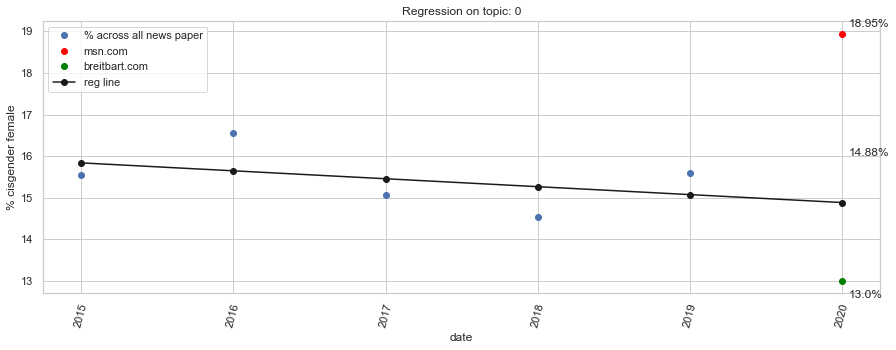

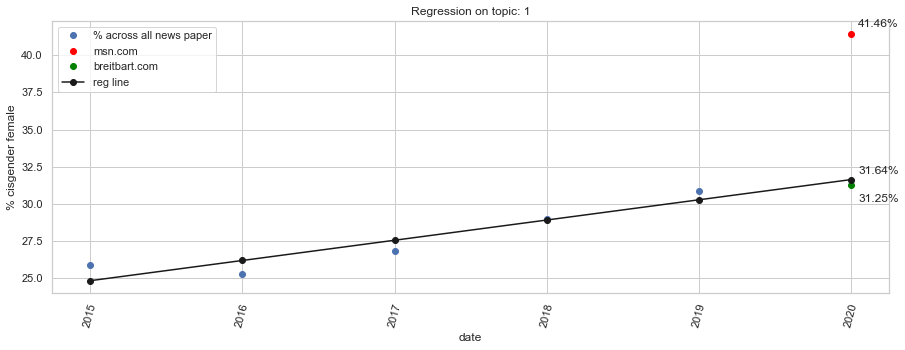

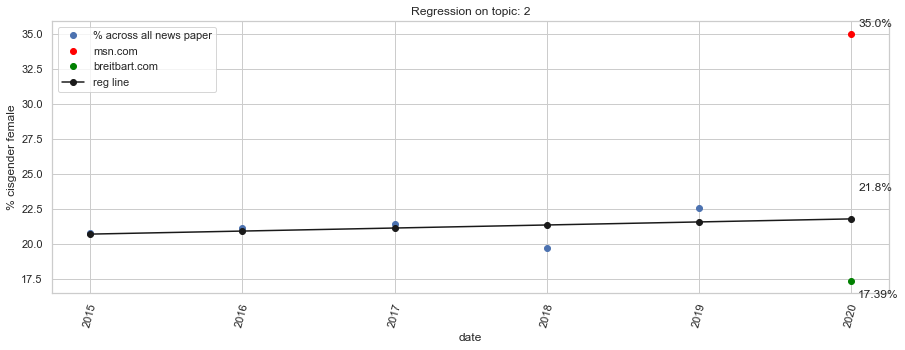

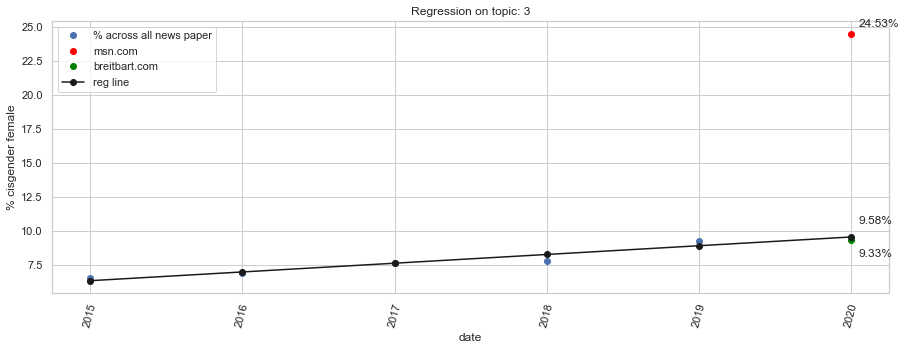

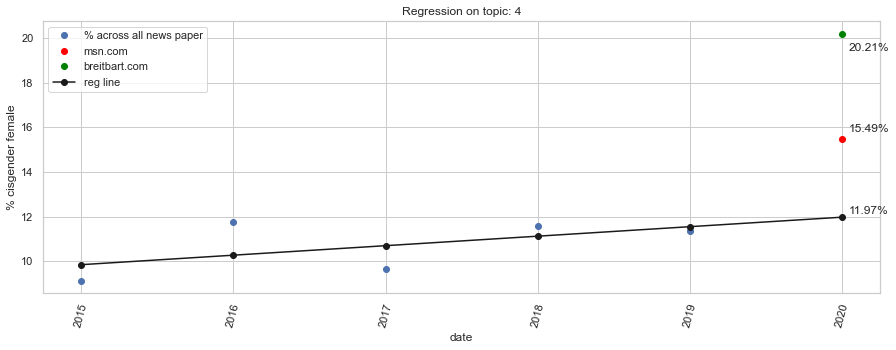

In [335]:
for i in range(5):
    plot_reg(i,'cisgender female', 'gender')

# Age

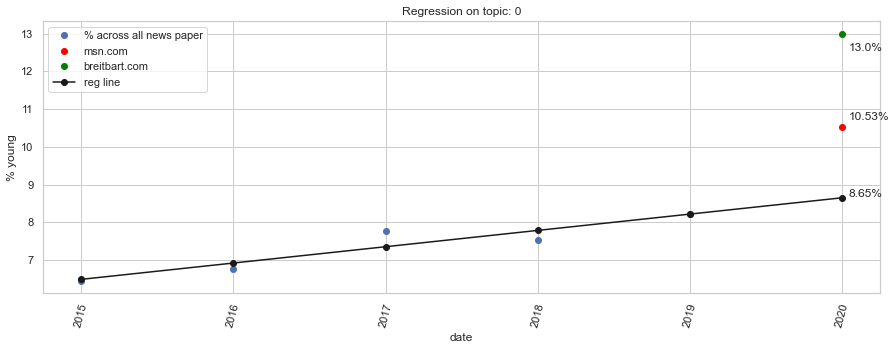

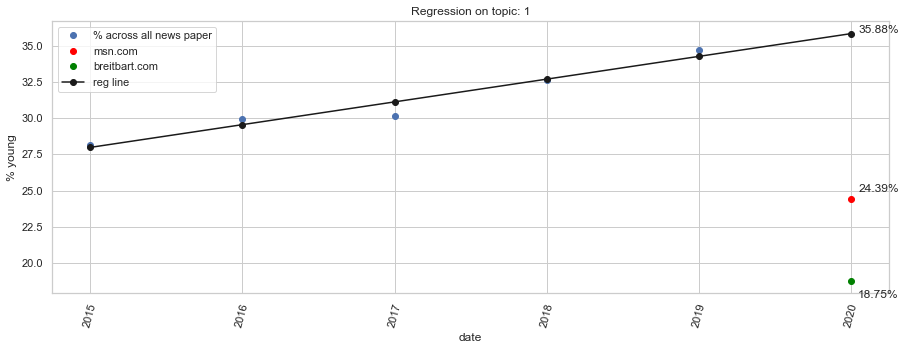

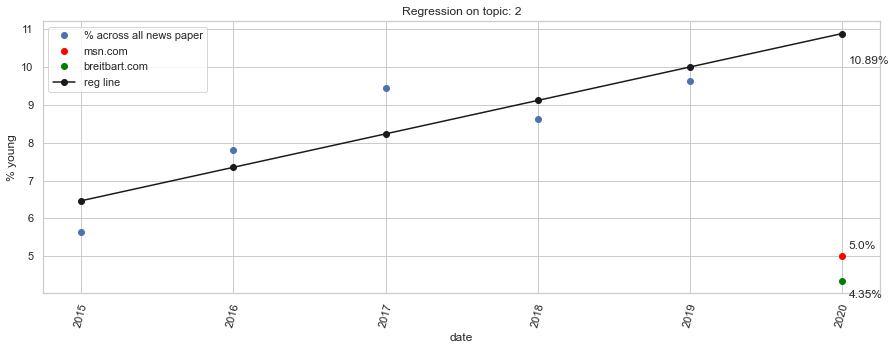

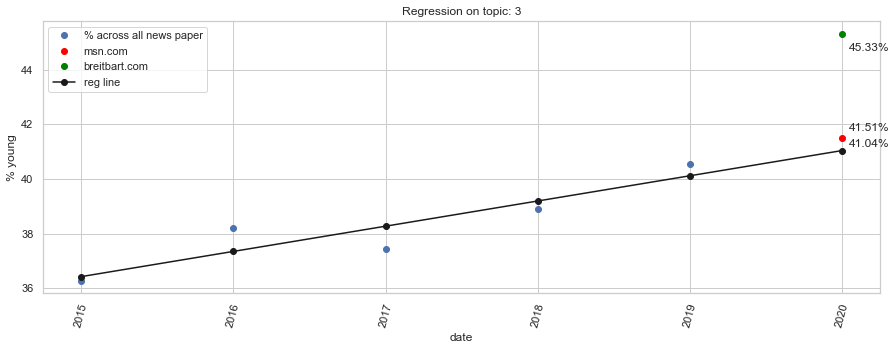

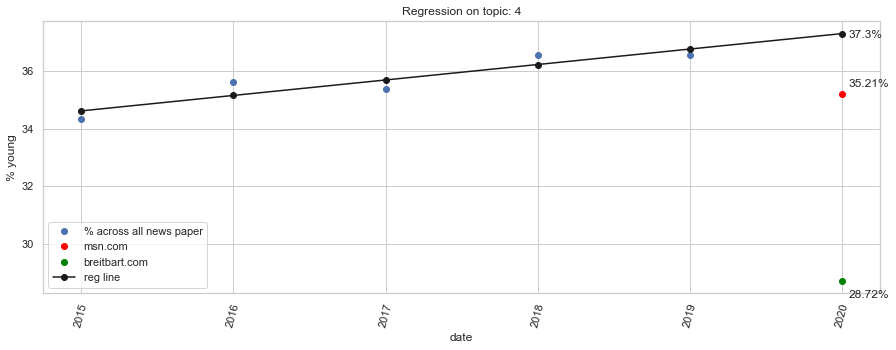

In [336]:
for i in range(5):
    plot_reg(i,'young', 'age_dummy')

# Nationality

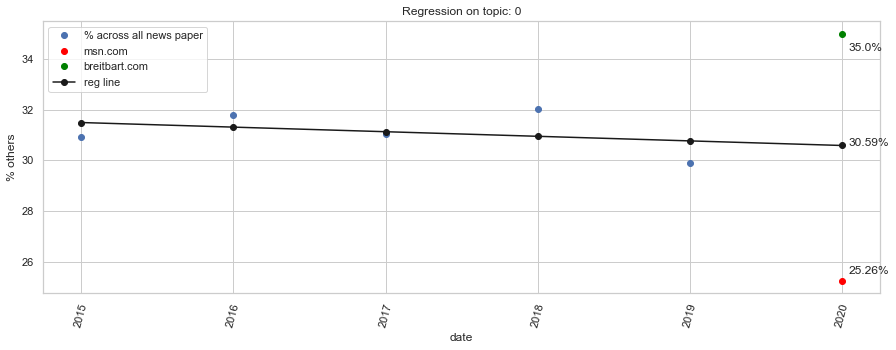

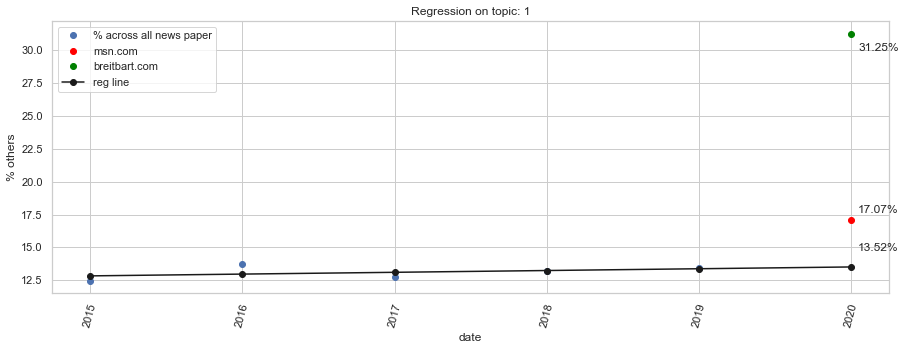

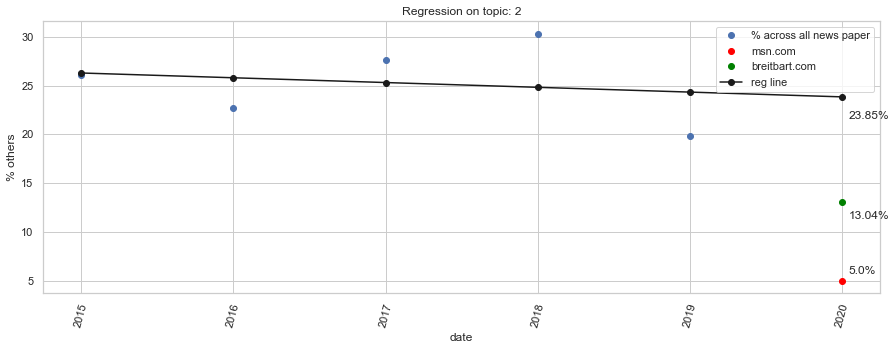

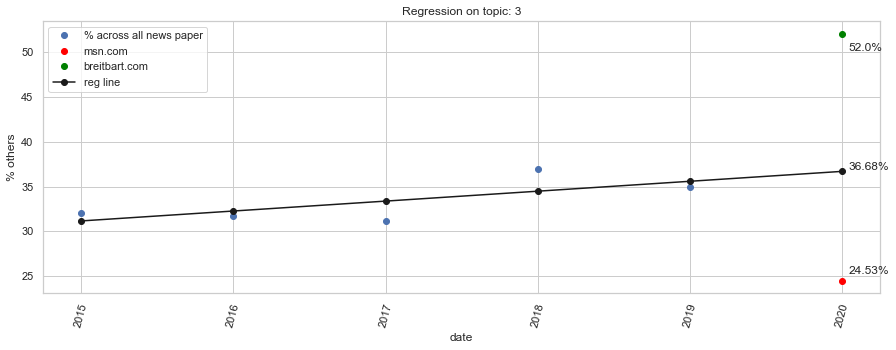

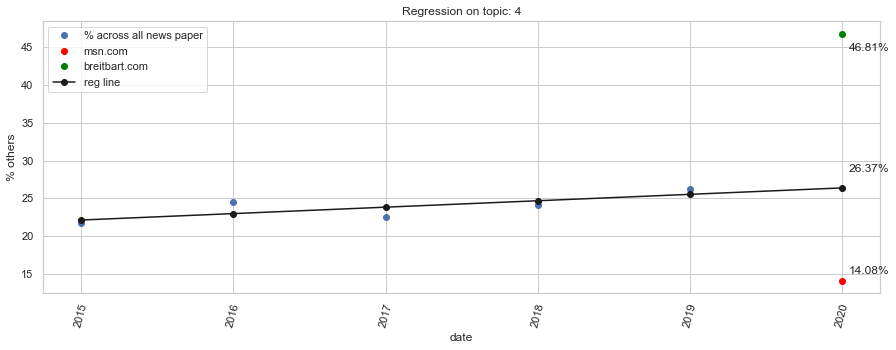

In [337]:
for i in range(5):
    plot_reg(i,'others', 'nat_dummy')